In [ ]:
import numpy as np 
import pandas as pd 
import re
!pip install --upgrade scikit-learn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import linear_model
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import SCORERS
import sys
from matplotlib import pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn import tree, svm,ensemble
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline
from yellowbrick.text import FreqDistVisualizer
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import PredefinedSplit
!pip install hypopt
from hypopt import GridSearch #FOR COMPATIBILITY REASONS IS NECESSARY TO MODIFY THE SOURCE CODE OF THE LIBRARY,
#TO RUN THE CELLS THAT USE THIS LIBRARY WE HAVE TO SUBSTITUTE THE SKLEARN.METRICS IN THE CODE WITH SKLEARN._METRICS (WITH THE UNDERSCORE)
from scipy.sparse import hstack
from sklearn.neighbors import KNeighborsClassifier
import tensorflow 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Input, Dense 
from tensorflow.keras.utils import to_categorical 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.python.framework.random_seed import set_random_seed
from keras.callbacks import EarlyStopping
from tensorflow.keras import metrics
from tensorflow.keras import regularizers

data_url = 'https://www.math.unipd.it/~dasan/disaster/'
train_csv = pd.read_csv(data_url + 'train.csv', sep=",") 
test_csv = pd.read_csv(data_url + 'test.csv', sep=",") 

In [ ]:
#DATA_PREPARATION
print(train_csv.head())

Y_train = train_csv["target"].values 
X_train = train_csv.values[:, 1:4] # extracting the columns keyword, location and text

keywords = X_train[:, 0]

for i in range(0, len(keywords)):         #remove nan from keywords
  if type(keywords[i]) is not str:
    keywords[i] = "nan"

print(np.sum(Y_train == 0)) 
print(np.sum(Y_train == 1)) 


#UNDER_SAMPLING

underSampler=RandomUnderSampler(random_state=123, sampling_strategy=1)
X_under, Y_under = underSampler.fit_resample(X_train,Y_train)
print(np.sum(Y_under == 0)) 
print(np.sum(Y_under == 1)) 


#let's print one example to check we picked the right columns
print(X_train[0])
text_samples=X_train[:,2]
print(text_samples[0])

################

#DICTIONARY_FOR_ACCENTS_CONVERSION
np.set_printoptions(threshold=sys.maxsize)

normalMap = {'À': 'A', 'Á': 'A', 'Â': 'A', 'Ã': 'A', 'Ä': 'A',
             'à': 'a', 'á': 'a', 'â': 'a', 'ã': 'a', 'ä': 'a','å':'a', 'ª': 'A',
             'È': 'E', 'É': 'E', 'Ê': 'E', 'Ë': 'E',
             'è': 'e', 'é': 'e', 'ê': 'e', 'ë': 'e',
             'Í': 'I', 'Ì': 'I', 'Î': 'I', 'Ï': 'I',
             'í': 'i', 'ì': 'i', 'î': 'i', 'ï': 'i',
             'Ò': 'O', 'Ó': 'O', 'Ô': 'O', 'Õ': 'O', 'Ö': 'O',
             'ò': 'o', 'ó': 'o', 'ô': 'o', 'õ': 'o', 'ö': 'o', 'º': 'O',
             'Ù': 'U', 'Ú': 'U', 'Û': 'U', 'Ü': 'U',
             'ù': 'u', 'ú': 'u', 'û': 'u', 'ü': 'u',
             'Ñ': 'N', 'ñ': 'n',
             'Ç': 'C', 'ç': 'c',
             '§': 'S',  '³': '3', '²': '2', '¹': '1'}
normalize = str.maketrans(normalMap)

#TEXT_CLEANING
processed_features = []
for sentence in range(0, len(text_samples)):
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', str(text_samples[sentence]))
    processed_feature = re.sub(r'[^\w\s]', '', processed_feature)
    processed_feature = re.sub(r'[|_|]', ' ', processed_feature)
    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature)

    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature)

    # Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)
    #removing accents
    processed_feature = processed_feature.translate(normalize)

    processed_feature = re.sub(r'http', '', processed_feature)

    # Converting to Lowercase
    processed_feature = processed_feature.lower()

    processed_features.append(processed_feature)




#COUNT_VECTORIZER
feature_computer = CountVectorizer(binary=False, lowercase=False, ngram_range=(1,3)) #binary False = counts, True = probability
feature_computer.fit(processed_features)
samples = feature_computer.transform(processed_features)

feature_computer_key= CountVectorizer(binary=False, lowercase=False, ngram_range=(1,1))
feature_computer_key.fit(keywords)
keywords_samples = feature_computer_key.transform(keywords)

feature_computer_cleaning = CountVectorizer(binary=False, lowercase=False, ngram_range=(1,1), min_df=0.001, stop_words = "english") #cleaning experiments
samples_cleaning = feature_computer_cleaning.fit_transform(processed_features)

samples_key = hstack([samples, keywords_samples])

#OVER_SAMPLING
ros = RandomOverSampler(random_state=42, sampling_strategy=1)
X_over, Y_over = ros.fit_resample(samples,Y_train)
X_over_key, Y_over_key = ros.fit_resample(samples_key,Y_train)
print(X_over.shape)
print(Y_over.size)
print(np.sum(Y_over == 0)) 
print(np.sum(Y_over == 1)) 


#SCALING
scaler = StandardScaler(with_mean=False)
scaler2 = StandardScaler(with_mean=False)

#SELECTING THE BEST FEATURES
kb = SelectKBest(chi2, k=2000)
kb.fit(X_over, Y_over)
X_new=kb.transform(X_over)
print(X_new.shape)


kbkey = SelectKBest(chi2, k=2200)
kbkey.fit(X_over_key, Y_over)
X_new_key=kbkey.transform(X_over_key)

features_number = X_new_key.shape[1]

#SCALING THE WHOLE TRANSFORMED DATA WITH KEYWORDS (FOR NN EVALUTION)
scaler2.fit(X_new_key)
X_over_scaled = scaler2.transform(X_new_key)



#SPLITTING THE TRASFORMED DATA IN TRAIN AND EVALUTION

#new_samples_train, new_samples_val, new_Y1_train, new_Y1_val = train_test_split(X_new_key, Y_over_key, train_size=0.85,stratify = Y_over,random_state = 2020)      split of the dataset containing the keywords
new_samples_train, new_samples_val, new_Y1_train, new_Y1_val = train_test_split(X_new, Y_over, train_size=0.85,stratify = Y_over,random_state = 2020)

#SCALING TRAIN AND VALIDATION SET
scaler.fit(new_samples_train)
new_samples_train_scaled = scaler.transform(new_samples_train)
new_samples_val_scaled=scaler.transform(new_samples_val)

   id keyword  ...                                               text target
0   1     NaN  ...  Our Deeds are the Reason of this #earthquake M...      1
1   4     NaN  ...             Forest fire near La Ronge Sask. Canada      1
2   5     NaN  ...  All residents asked to 'shelter in place' are ...      1
3   6     NaN  ...  13,000 people receive #wildfires evacuation or...      1
4   7     NaN  ...  Just got sent this photo from Ruby #Alaska as ...      1

[5 rows x 5 columns]
4342
3271
3271
3271
['nan' nan
 'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all']
Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
(8684, 170196)
8684
4342
4342
(8684, 2000)


In [ ]:
#PREPROCESSING THE TEST SAMPLES WITH THE FUNCTIONS FITTED IN THE PREVIOUS CELL

X_test = test_csv.values[:, 1:4]
print(test_csv)
 
print(np.sum(Y_train == 0))
print(np.sum(Y_train == 1))
 
keywords = X_test[:, 0]
 
text_samples_test=X_test[:,2]
print(text_samples[0])
 
################
 
#DICTIONARY_FOR_ACCENTS_CONVERSION 
np.set_printoptions(threshold=sys.maxsize)
 
normalMap = {'À': 'A', 'Á': 'A', 'Â': 'A', 'Ã': 'A', 'Ä': 'A',
             'à': 'a', 'á': 'a', 'â': 'a', 'ã': 'a', 'ä': 'a','å':'a', 'ª': 'A',
             'È': 'E', 'É': 'E', 'Ê': 'E', 'Ë': 'E',
             'è': 'e', 'é': 'e', 'ê': 'e', 'ë': 'e',
             'Í': 'I', 'Ì': 'I', 'Î': 'I', 'Ï': 'I',
             'í': 'i', 'ì': 'i', 'î': 'i', 'ï': 'i',
             'Ò': 'O', 'Ó': 'O', 'Ô': 'O', 'Õ': 'O', 'Ö': 'O',
             'ò': 'o', 'ó': 'o', 'ô': 'o', 'õ': 'o', 'ö': 'o', 'º': 'O',
             'Ù': 'U', 'Ú': 'U', 'Û': 'U', 'Ü': 'U',
             'ù': 'u', 'ú': 'u', 'û': 'u', 'ü': 'u',
             'Ñ': 'N', 'ñ': 'n',
             'Ç': 'C', 'ç': 'c',
             '§': 'S', '³': '3', '²': '2', '¹': '1'}
normalize = str.maketrans(normalMap)
 
#TEXT_CLEANING 
processed_features = []
for sentence in range(0, len(text_samples_test)):
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', str(text_samples_test[sentence]))
    processed_feature = re.sub(r'[^\w\s]', '', processed_feature)
    processed_feature = re.sub(r'[|_|]', ' ', processed_feature)
    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)
 
    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature)
 
    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)
 
    # Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)
    processed_feature = re.sub('http', '', processed_feature)
    #removing accents
    processed_feature = processed_feature.translate(normalize)
 
    #removing words less than 3 char
    #processed_feature = re.sub(r'\b\w{1,3}\b', '', processed_feature)
 
    # Converting to Lowercase
    processed_feature = processed_feature.lower()
 
    processed_features.append(processed_feature)
 
     
#remove nan from keywords
for i in range(0, len(keywords)):
  if type(keywords[i]) is not str:
    keywords[i] = "nan"
 
 
samples = feature_computer.transform(processed_features)
keywords_samples = feature_computer_key.transform(keywords)
 
samples_key = hstack([samples, keywords_samples])
 
 
 
# CHI-SQUARE
samples_chi = kb.transform(samples)
samples_chi_key = kbkey.transform(samples_key)
 
samples_test_scaled = scaler.transform(samples_chi)
samples_test_scaled_nn = scaler2.transform(samples_chi_key)

         id keyword location                                               text
0         0     NaN      NaN                 Just happened a terrible car crash
1         2     NaN      NaN  Heard about #earthquake is different cities, s...
2         3     NaN      NaN  there is a forest fire at spot pond, geese are...
3         9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4        11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan
...     ...     ...      ...                                                ...
3258  10861     NaN      NaN  EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259  10865     NaN      NaN  Storm in RI worse than last hurricane. My city...
3260  10868     NaN      NaN  Green Line derailment in Chicago http://t.co/U...
3261  10874     NaN      NaN  MEG issues Hazardous Weather Outlook (HWO) htt...
3262  10875     NaN      NaN  #CityofCalgary has activated its Municipal Eme...

[3263 rows x 4 columns]
4342
3271
Our D

In [ ]:
def download_predictions_to_file(id_array, predictions_array):
  # This function, given a numpy array with the ids of the test tweets and a numpy array with the corresponding predictions, 
  # creates and let's you download a prediction file suitable to be uploaded to the Kaggle website

  id_array = id_array.reshape(len(id_array),1) # making sure the arrays are of the size requested by hstack(), i.e. (x,1) instead of (x,) 
  predictions_array = predictions_array.reshape(len(predictions_array),1)

  from google.colab import files
  result = pd.DataFrame(np.hstack((id_array, predictions_array)), columns=['id','target'])
  result.to_csv('prediction_file.csv', index=False)
  files.download('prediction_file.csv')


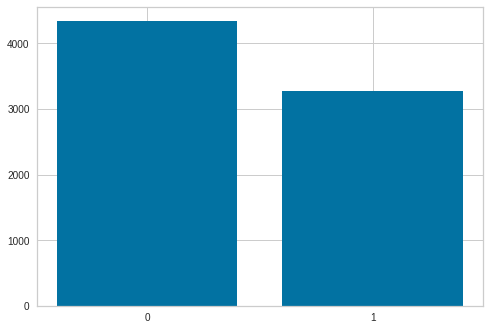

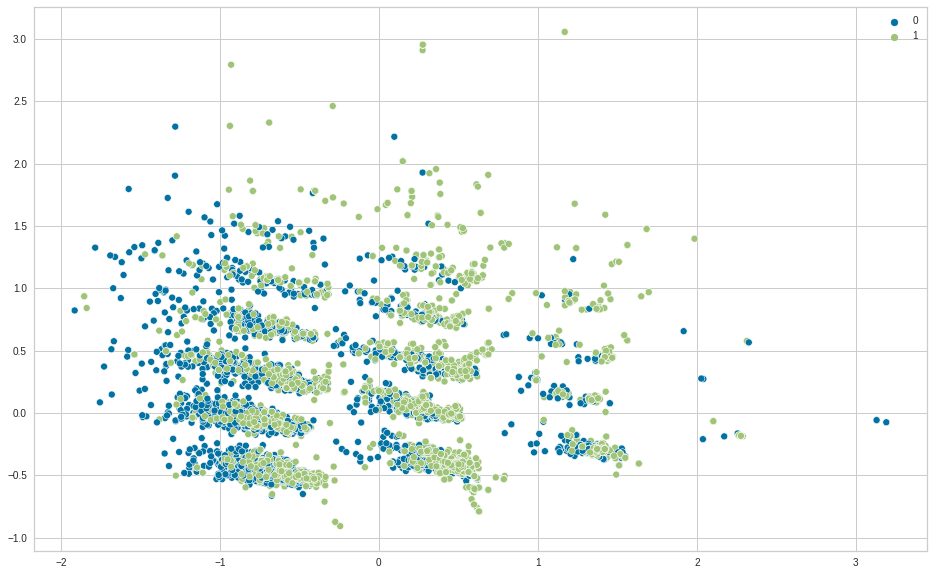

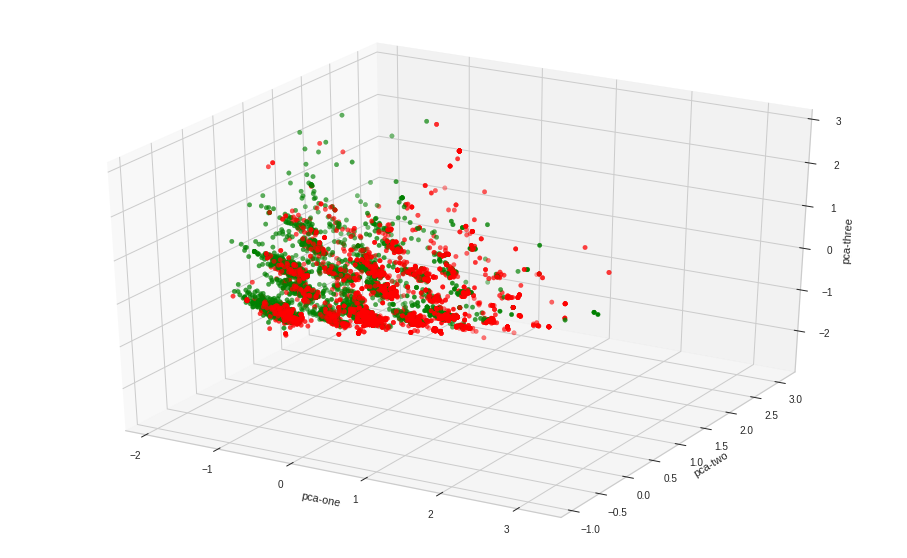

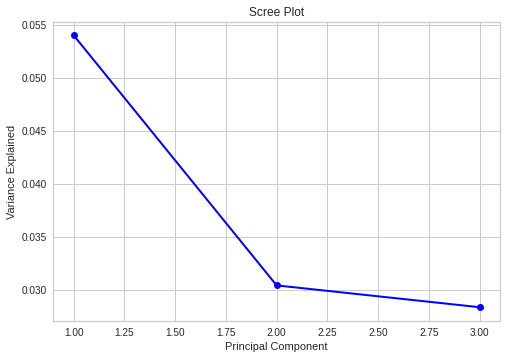

In [ ]:
#2D AND 3D PLOT OF THE DATASET WITH PCA

ax=plt.subplot()
bars=ax.bar(["0","1"], [(np.sum(Y_train == 0)) ,(np.sum(Y_train == 1)) ])
plt.show()

pca = PCA(n_components=3) #3 components for showing the graph. Modify the number of components to compute features for training the models
pca_result = pca.fit_transform(X_new.toarray())
pcaone = pca_result[:,0]
pcatwo= pca_result[:,1] 
pcathree=pca_result[:,2]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=pcaone, y=pcatwo,
    hue=Y_over,
    #palette=sns.color_palette("hl", 10),
    #data=[pcaone,pcatwo],
   legend="full",
      #alpha=0.2
)
cols=[]
for y in Y_over:
  if y==0:
    cols.append('green')
  elif y==1:
    cols.append('red')
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=pcaone, 
    ys=pcatwo, 
    zs=pcathree, 
    c=cols, 
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

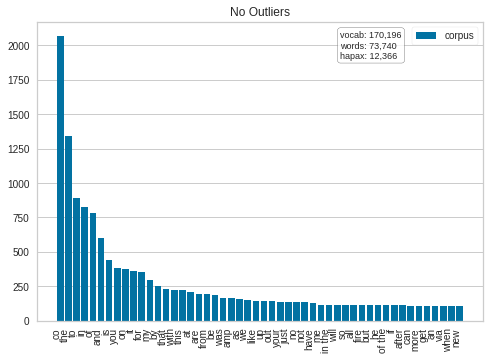

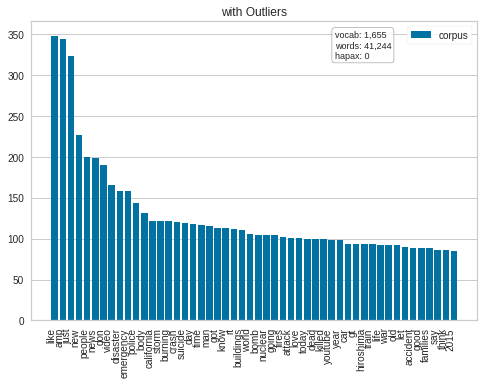

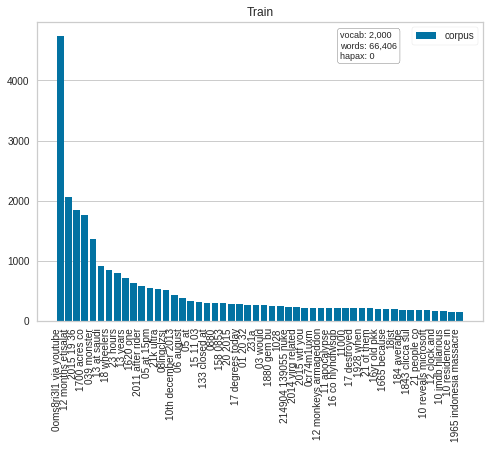

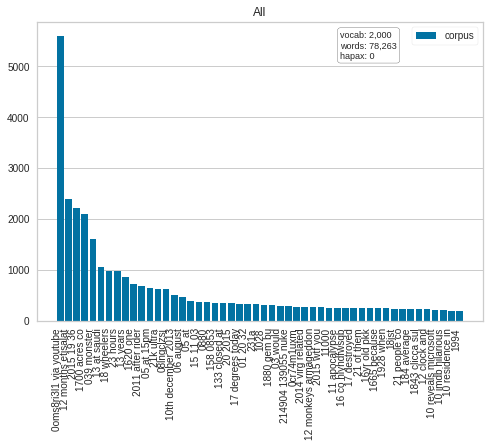

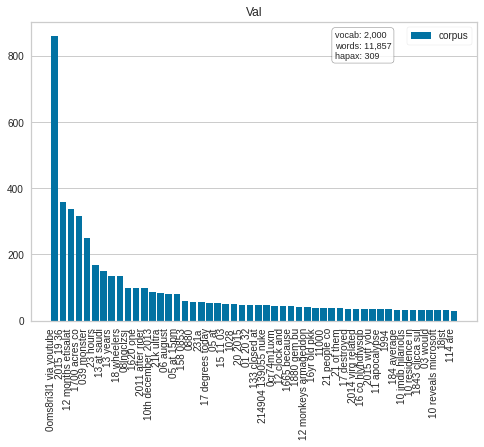

In [ ]:
#BAR PLOT FREQUENCIES OUTLIERS VS CLEANED

features   = feature_computer.get_feature_names_out()
visualizer = FreqDistVisualizer(features=features, orient='v', title="No Outliers")
visualizer.fit(samples)
visualizer.show()
features_cleaning   = feature_computer_cleaning.get_feature_names_out()
visualizer2 = FreqDistVisualizer(features=features_cleaning, orient='v', title="with Outliers")
visualizer2.fit(samples_cleaning)
visualizer2.show()
features_train   = feature_computer.get_feature_names_out()
visualizer2 = FreqDistVisualizer(features=features_train, orient='v', title="Train")
visualizer2.fit(new_samples_train)
visualizer2.show()
features_train_all  = feature_computer.get_feature_names_out()
visualizer2 = FreqDistVisualizer(features=features_train_all, orient='v', title="All")
visualizer2.fit(X_new)
visualizer2.show()
features_val  = feature_computer.get_feature_names_out()
visualizer2 = FreqDistVisualizer(features=features_val, orient='v', title="Val")
visualizer2.fit(new_samples_val)
visualizer2.show()




In [ ]:
#SVM GRID SEARCH

#FOR COMPATIBILITY REASONS IS NECESSARY TO MODIFY THE SOURCE CODE OF THE LIBRARY,
#TO RUN THE CELLS THAT USE THIS LIBRARY WE HAVE TO SUBSTITUTE THE SKLEARN.METRICS IN THE CODE WITH SKLEARN._METRICS (WITH THE UNDERSCORE)

param_svc = {
    "kernel": [ "rbf","sigmoid","poly"],
    "gamma" : ["scale", "auto"],
    "shrinking" : [True, False]
}


SVCclf = svm.SVC()
SVCGS = GridSearch(SVCclf, param_grid=param_svc)
SVCGS.fit(new_samples_train_scaled, new_Y1_train, new_samples_val_scaled, new_Y1_val, scoring='accuracy')
# SVCGS.fit(new_samples_train_scaled, new_Y1_train, new_samples_val_scaled, new_Y1_val, scoring='recall')

print(SVCGS.get_best_score())
print(SVCGS.get_best_params())



100%|██████████| 12/12 [00:35<00:00,  2.96s/it]

0.8181120491174213
{'gamma': 'auto', 'kernel': 'rbf', 'shrinking': False}


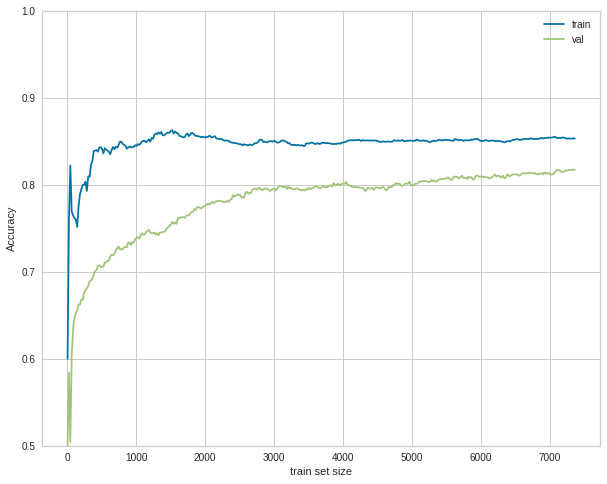

In [ ]:
#SVM ACCURACY PLOT 

train_size = np.arange(5, new_samples_train_scaled.shape[0], 20)
accuracy_values_train = []
accuracy_values_val = []
 
for i in train_size:
    lr = svm.SVC(gamma="auto",kernel="rbf",shrinking=False)
    lr.fit(new_samples_train_scaled[0:i, :], new_Y1_train[0:i])
    train_prediction = lr.predict(new_samples_train_scaled[0:i, :])
    val_prediction = lr.predict(new_samples_val_scaled)
    accuracy_values_train.append(accuracy_score(new_Y1_train[0:i],train_prediction))
    accuracy_values_val.append(accuracy_score(new_Y1_val,val_prediction))
################
 
fig = plt.figure(figsize=(10,8))
plt.plot(train_size, accuracy_values_train, label="train")
plt.plot(train_size, accuracy_values_val, label="val")
plt.xlabel("train set size")
plt.ylabel("Accuracy")
plt.ylim([0.5, 1])
plt.legend()
plt.show()

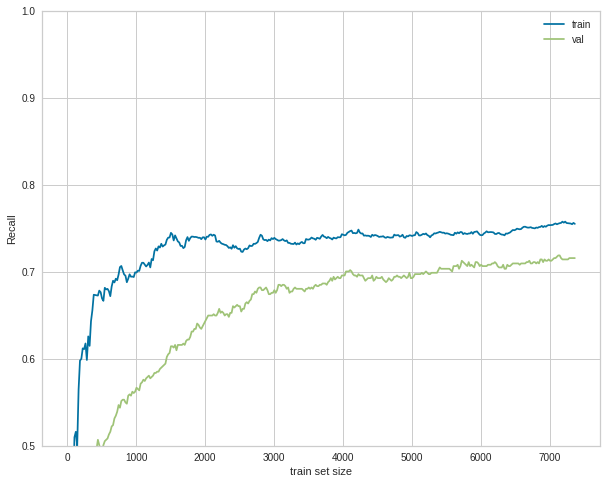

In [ ]:
#SVM RECALL PLOT

train_size = np.arange(5, new_samples_train_scaled.shape[0], 20)
accuracy_values_train = []
accuracy_values_val = []
 
for i in train_size:
    lr = svm.SVC(gamma="auto",kernel="rbf",shrinking=False)
    lr.fit(new_samples_train_scaled[0:i, :], new_Y1_train[0:i])
    train_prediction = lr.predict(new_samples_train_scaled[0:i, :])
    val_prediction = lr.predict(new_samples_val_scaled)
    accuracy_values_train.append(recall_score(new_Y1_train[0:i],train_prediction))
    accuracy_values_val.append(recall_score(new_Y1_val,val_prediction))
################
 
fig = plt.figure(figsize=(10,8))
plt.plot(train_size, accuracy_values_train, label="train")
plt.plot(train_size, accuracy_values_val, label="val")
plt.xlabel("train set size")
plt.ylabel("Recall")
plt.ylim([0.5, 1])
plt.legend()
plt.show()

In [ ]:
# LOGISTIC REGRESSION GRID SEARCH

#FOR COMPATIBILITY REASONS IS NECESSARY TO MODIFY THE SOURCE CODE OF THE LIBRARY,
#TO RUN THE CELLS THAT USE THIS LIBRARY WE HAVE TO SUBSTITUTE THE SKLEARN.METRICS IN THE CODE WITH SKLEARN._METRICS (WITH THE UNDERSCORE)

param_lr2 = {
    'C' : [0.1, 0.5, 1],
    'fit_intercept' : [True, False],
    'class_weight' : [None, "balanced"],
    'solver' : ["newton-cg", "sag", "lbfgs", "liblinear"],
    'max_iter' : [ 100, 100000]
    
}


LRclf = linear_model.LogisticRegression()
LRGS = GridSearch(LRclf, param_grid=param_lr2)
LRGS.fit(new_samples_train_scaled, new_Y1_train, new_samples_val_scaled, new_Y1_val, scoring='accuracy')
# LRGS.fit(new_samples_train_scaled, new_Y1_train, new_samples_val_scaled, new_Y1_val, scoring='recall')

print(LRGS.get_best_score())
print(LRGS.get_best_params())
#results=LRGS.predict(samples_test_scaled)

  0%|          | 0/96 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
  1%|          | 1/96 [00:00<00:34,  2.78it/s]/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
  5%|▌         | 5/96 [00:00<00:14,  6.29it/s]/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  Conve

0.8173445894090561
{'C': 0.1, 'class_weight': None, 'fit_intercept': True, 'max_iter': 100000, 'solver': 'sag'}


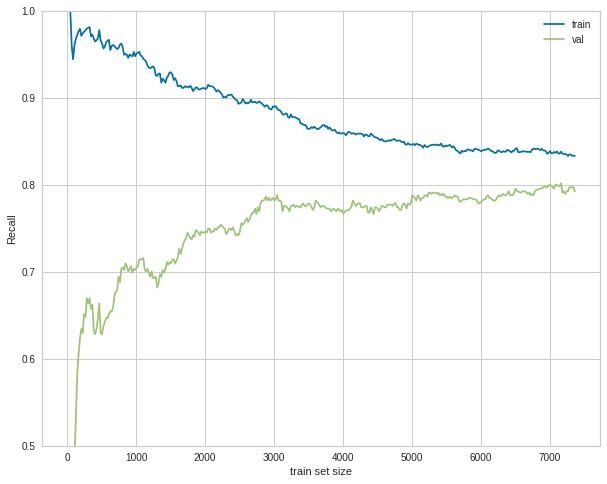

In [ ]:
#LOGISTIC REGRESSION RECALL PLOT

train_size = np.arange(5, new_samples_train_scaled.shape[0], 20)
accuracy_values_train = []
accuracy_values_val = []
 
for i in train_size:
    lr = linear_model.LogisticRegression(C= 0.1, class_weight= None, fit_intercept= True, max_iter= 100000, solver='sag')
    lr.fit(new_samples_train_scaled[0:i, :], new_Y1_train[0:i])
    train_prediction = lr.predict(new_samples_train_scaled[0:i, :])
    val_prediction = lr.predict(new_samples_val_scaled)
    accuracy_values_train.append(recall_score(new_Y1_train[0:i],train_prediction))
    accuracy_values_val.append(recall_score(new_Y1_val,val_prediction))
################
 
fig = plt.figure(figsize=(10,8))
plt.plot(train_size, accuracy_values_train, label="train")
plt.plot(train_size, accuracy_values_val, label="val")
plt.xlabel("train set size")
plt.ylabel("Recall")
plt.ylim([0.5, 1])
plt.legend()
plt.show()

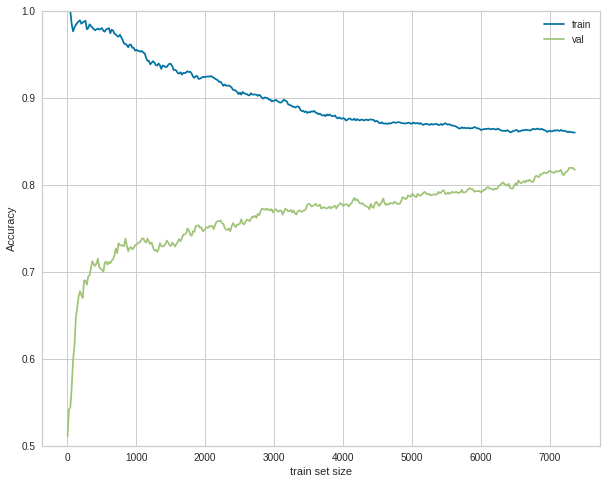

In [ ]:
#LOGISTIC REGRESSION ACCURACY PLOT

train_size = np.arange(5, new_samples_train_scaled.shape[0], 20)
accuracy_values_train = []
accuracy_values_val = []
 
for i in train_size:
    lr = linear_model.LogisticRegression(C= 0.1, class_weight= None, fit_intercept= True, max_iter= 100000, solver='sag')
    lr.fit(new_samples_train_scaled[0:i, :], new_Y1_train[0:i])
    train_prediction = lr.predict(new_samples_train_scaled[0:i, :])
    val_prediction = lr.predict(new_samples_val_scaled)
    accuracy_values_train.append(accuracy_score(new_Y1_train[0:i],train_prediction))
    accuracy_values_val.append(accuracy_score(new_Y1_val,val_prediction))
################
 
fig = plt.figure(figsize=(10,8))
plt.plot(train_size, accuracy_values_train, label="train")
plt.plot(train_size, accuracy_values_val, label="val")
plt.xlabel("train set size")
plt.ylabel("Accuracy")
plt.ylim([0.5, 1])
plt.legend()
plt.show()

In [ ]:
# RANDOM FOREST GRID SEARCH

#FOR COMPATIBILITY REASONS IS NECESSARY TO MODIFY THE SOURCE CODE OF THE LIBRARY,
#TO RUN THE CELLS THAT USE THIS LIBRARY WE HAVE TO SUBSTITUTE THE SKLEARN.METRICS IN THE CODE WITH SKLEARN._METRICS (WITH THE UNDERSCORE)

param_forest = {
    "criterion" :["gini", "entropy"],
    "max_depth" : [100,1000],
    "n_estimators" : [100, 1000]
}


RTclf = ensemble.RandomForestClassifier()
RTGS = GridSearch(RTclf, param_grid=param_forest)
RTGS.fit(new_samples_train_scaled, new_Y1_train,new_samples_val_scaled,new_Y1_val,scoring="accuracy")
# RTGS.fit(new_samples_train_scaled, new_Y1_train,new_samples_val_scaled,new_Y1_val,scoring="recall")
print(RTGS.get_best_params())
print(RTGS.get_best_score())


100%|██████████| 8/8 [02:33<00:00, 19.13s/it]


{'criterion': 'entropy', 'max_depth': 1000, 'n_estimators': 1000}
0.8472755180353031


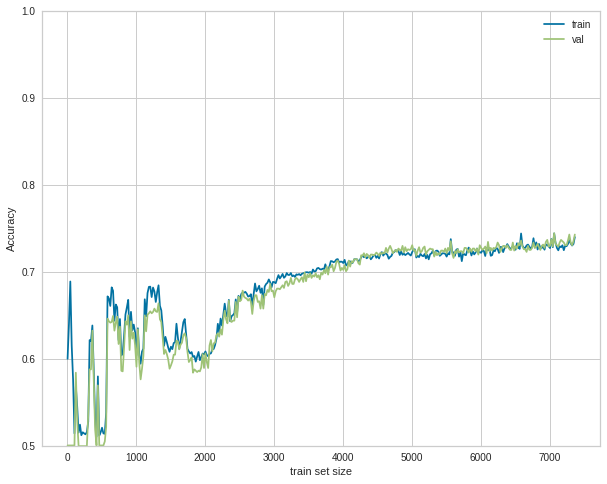

In [ ]:
#RANDOM FOREST ACCURACY PLOT

train_size = np.arange(5, new_samples_train_scaled.shape[0], 20)
accuracy_values_train = []
accuracy_values_val = []
 
for i in train_size:
    lr = ensemble.RandomForestClassifier(n_estimators=1000,criterion="entropy", max_depth=1000)
    lr.fit(new_samples_train_scaled[0:i, :], new_Y1_train[0:i])
    train_prediction = lr.predict(new_samples_train_scaled[0:i, :])
    val_prediction = lr.predict(new_samples_val_scaled)
    accuracy_values_train.append(accuracy_score(new_Y1_train[0:i],train_prediction))
    accuracy_values_val.append(accuracy_score(new_Y1_val,val_prediction))
################
 
fig = plt.figure(figsize=(10,8))
plt.plot(train_size, accuracy_values_train, label="train")
plt.plot(train_size, accuracy_values_val, label="val")
plt.xlabel("train set size")
plt.ylabel("Accuracy")
plt.ylim([0.5, 1])
plt.legend()
plt.show()

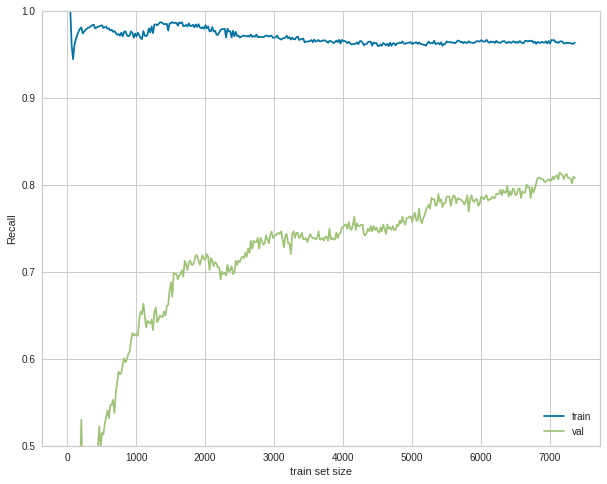

In [ ]:
#RANDOM FOREST RECALL PLOT

train_size = np.arange(5, new_samples_train_scaled.shape[0], 20)
accuracy_values_train = []
accuracy_values_val = []
 
for i in train_size:
    lr = ensemble.RandomForestClassifier(criterion="entropy", max_depth=1000, n_estimators=1000)
    lr.fit(new_samples_train_scaled[0:i, :], new_Y1_train[0:i])
    train_prediction = lr.predict(new_samples_train_scaled[0:i, :])
    val_prediction = lr.predict(new_samples_val_scaled)
    accuracy_values_train.append(recall_score(new_Y1_train[0:i],train_prediction))
    accuracy_values_val.append(recall_score(new_Y1_val,val_prediction))
################
 
fig = plt.figure(figsize=(10,8))
plt.plot(train_size, accuracy_values_train, label="train")
plt.plot(train_size, accuracy_values_val, label="val")
plt.xlabel("train set size")
plt.ylabel("Recall")
plt.ylim([0.5, 1])
plt.legend()
plt.show()

In [ ]:
# SVM TEST PREDICTION

SVCGS.predict(samples_test_scaled)
test_index = test_csv.values[:, 0]

download_predictions_to_file(test_index, results)

In [ ]:
#PERCEPTRON GRID PERCEPTRON

#FOR COMPATIBILITY REASONS IS NECESSARY TO MODIFY THE SOURCE CODE OF THE LIBRARY,
#TO RUN THE CELLS THAT USE THIS LIBRARY WE HAVE TO SUBSTITUTE THE SKLEARN.METRICS IN THE CODE WITH SKLEARN._METRICS (WITH THE UNDERSCORE)

param_percep = {
    "penalty":["l2","l1","elasticnet"],
    'fit_intercept' : [True, False],
    'shuffle' : [True, False],
}

PCclf = linear_model.Perceptron()
PCGS = GridSearch(PCclf, param_grid=param_percep)
PCGS.fit(new_samples_train_scaled, new_Y1_train, new_samples_val_scaled, new_Y1_val, scoring = "accuracy")
# PCGS.fit(new_samples_train_scaled, new_Y1_train,new_samples_val_scaled,new_Y1_val, scoring = "recall")

print(PCGS.get_best_params())
print(PCGS.get_best_score())

100%|██████████| 12/12 [00:00<00:00, 45.33it/s]

{'fit_intercept': True, 'penalty': 'l1', 'shuffle': False}
0.7858787413660783


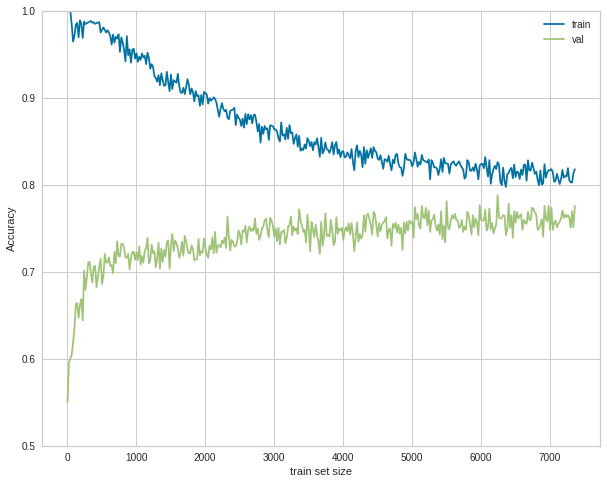

In [ ]:
#PERCEPTRON ACCURACY PLOT

train_size = np.arange(5, new_samples_train_scaled.shape[0], 20)
accuracy_values_train = []
accuracy_values_val = []
 
for i in train_size:
    pc = linear_model.Perceptron()
    pc.fit(new_samples_train_scaled[0:i, :], new_Y1_train[0:i])
    train_prediction = pc.predict(new_samples_train_scaled[0:i, :])
    val_prediction = pc.predict(new_samples_val_scaled)
    accuracy_values_train.append(accuracy_score(new_Y1_train[0:i],train_prediction))
    accuracy_values_val.append(accuracy_score(new_Y1_val,val_prediction))
################
 
fig = plt.figure(figsize=(10,8))
plt.plot(train_size, accuracy_values_train, label="train")
plt.plot(train_size, accuracy_values_val, label="val")
plt.xlabel("train set size")
plt.ylabel("Accuracy")
plt.ylim([0.5, 1])
plt.legend()
plt.show()

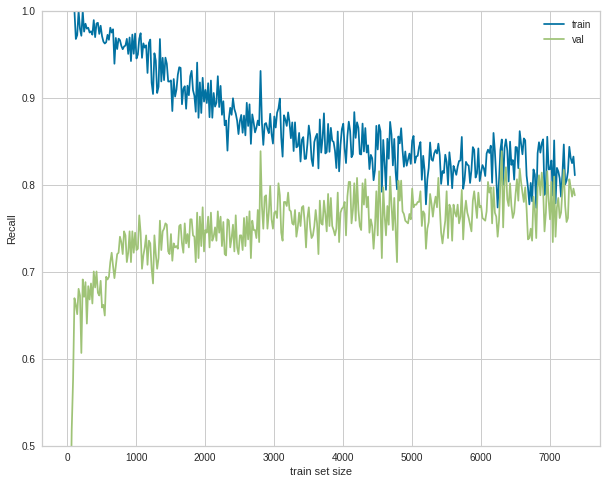

In [ ]:
#PERCEPTRON RECALL PLOT

train_size = np.arange(5, new_samples_train_scaled.shape[0], 20)
accuracy_values_train = []
accuracy_values_val = []
 
for i in train_size:
    pc = linear_model.Perceptron()
    pc.fit(new_samples_train_scaled[0:i, :], new_Y1_train[0:i])
    train_prediction = pc.predict(new_samples_train_scaled[0:i, :])
    val_prediction = pc.predict(new_samples_val_scaled)
    accuracy_values_train.append(recall_score(new_Y1_train[0:i],train_prediction))
    accuracy_values_val.append(recall_score(new_Y1_val,val_prediction))
################
 
fig = plt.figure(figsize=(10,8))
plt.plot(train_size, accuracy_values_train, label="train")
plt.plot(train_size, accuracy_values_val, label="val")
plt.xlabel("train set size")
plt.ylabel("Recall")
plt.ylim([0.5, 1])
plt.legend()
plt.show()

In [ ]:
#NEAREST_NEIGHBORS GRID SEARCH

#FOR COMPATIBILITY REASONS IS NECESSARY TO MODIFY THE SOURCE CODE OF THE LIBRARY,
#TO RUN THE CELLS THAT USE THIS LIBRARY WE HAVE TO SUBSTITUTE THE SKLEARN.METRICS IN THE CODE WITH SKLEARN._METRICS (WITH THE UNDERSCORE)

param_knn = {
    'n_neighbors' : range(2, 30),
    'p' : [1, 2],    
}

knn= KNeighborsClassifier()
clf = GridSearch(knn, param_grid=param_knn)
clf.fit(new_samples_train_scaled, new_Y1_train, new_samples_val_scaled, new_Y1_val, scoring = "accuracy")
# clf.fit(new_samples_train_scaled, new_Y1_train, new_samples_val_scaled, new_Y1_val, scoring = "recall")

print(clf.get_best_params())
print(clf.get_best_score())


100%|██████████| 56/56 [00:25<00:00,  2.22it/s]

{'n_neighbors': 11, 'p': 2}
0.7912509593246354


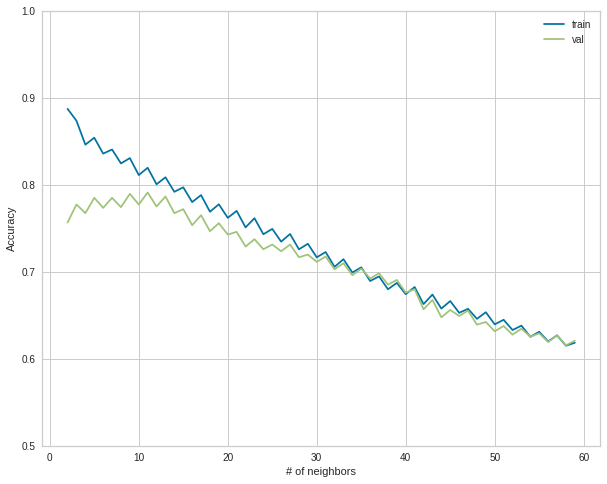

In [ ]:
#NEAREST_NEIGHBOR_PLOT

accuracy_train=[]
accuracy_val=[]

for k in range(2, 60):
  knn= KNeighborsClassifier(n_neighbors=k, p=2)
  knn.fit(new_samples_train_scaled, new_Y1_train)
  predictions_t = knn.predict(new_samples_train_scaled)
  predictions_v = knn.predict(new_samples_val_scaled)
  accuracy_train.append(accuracy_score(new_Y1_train,predictions_t))
  accuracy_val.append(accuracy_score(new_Y1_val,predictions_v))

fig = plt.figure(figsize=(10,8))
plt.plot(range(2, 60), accuracy_train, label="train")
plt.plot(range(2, 60), accuracy_val, label="val")
plt.xlabel("# of neighbors")
plt.ylabel("Accuracy")
plt.ylim([0.5, 1])
plt.legend()
plt.show()

In [ ]:
#NEURAL_NETWORK GRID SEARCH

np.random.seed(456)
set_random_seed(2)

Y1_train_nn = to_categorical(new_Y1_train, 2)
Y1_val_nn = to_categorical(new_Y1_val, 2)

epoch = [50]
hidden_layer = [2]
units = [50]
batch_size = [16]
optimizers = ["sgd", "RMSprop"]
activation = ['relu', "selu", "tanh"]

def runNN(act, opt, ep, h_lay, un, b):
    model = Sequential() 
    model.add(Dense(input_dim = 2000, units=un , activation=act)) 
    for i in range(0, h_lay):
        model.add(Dense(units=un, activation=act))
    model.add(Dense(2, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', 
              optimizer=opt,  
              metrics=['accuracy', metrics.Recall()])
    model.fit(new_samples_train_scaled, Y1_train_nn, epochs=ep, batch_size=b, verbose=1)
    results = model.evaluate(new_samples_val_scaled, Y1_val_nn, verbose=1)
    return results

accuracy_max = 0;

for a in activation:
  for o in optimizers:
    for e in epoch:
        for l in hidden_layer:
            for u in units:
                for b in batch_size:
                    result = runNN(a, o, e, l, u, b )
                    if result[1]>accuracy_max:
                        accuracy_max=result[1]
                        best_param = [e,l, u, b, a, o]

print("epoch:", best_param[0], "hidden layers:", best_param[1], "units:", best_param[2], "batch size:", best_param[3], "activation:", best_param[4], "optimizers:", best_param[5])
print("accuracy", accuracy_max)
print("recall", result[2])

a
a
Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_9/dense_32/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_9/dense_32/embedding_lookup_sparse/Reshape:0", shape=(None, 50), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_9/dense_32/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


462/462 [==============================] - 2s 2ms/step - loss: 0.6292 - accuracy: 0.6205 - recall_1: 0.5885
Epoch 2/50
462/462 [==============================] - 1s 2ms/step - loss: 0.4615 - accuracy: 0.7976 - recall_1: 0.7998
Epoch 3/50
462/462 [==============================] - 1s 2ms/step - loss: 0.3683 - accuracy: 0.8332 - recall_1: 0.8346
Epoch 4/50
462/462 [==============================] - 1s 2ms/step - loss: 0.3229 - accuracy: 0.8596 - recall_1: 0.8596
Epoch 5/50
462/462 [==============================] - 1s 2ms/step - loss: 0.2920 - accuracy: 0.8745 - recall_1: 0.8728
Epoch 6/50
462/462 [==============================] - 1s 2ms/step - loss: 0.2662 - accuracy: 0.8865 - recall_1: 0.8855
Epoch 7/50
462/462 [==============================] - 1s 2ms/step - loss: 0.2458 - accuracy: 0.8969 - recall_1: 0.8955
Epoch 8/50
462/462 [==============================] - 1s 2ms/step - loss: 0.2284 - accuracy: 0.9050 - recall_1: 0.9045
Epoch 9/50
462/462 [==============================] - 1s 2m

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_10/dense_36/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_10/dense_36/embedding_lookup_sparse/Reshape:0", shape=(None, 50), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_10/dense_36/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


462/462 [==============================] - 2s 3ms/step - loss: 0.4849 - accuracy: 0.7663 - recall_2: 0.7660
Epoch 2/50
462/462 [==============================] - 1s 3ms/step - loss: 0.3789 - accuracy: 0.8376 - recall_2: 0.8373
Epoch 3/50
462/462 [==============================] - 1s 3ms/step - loss: 0.3548 - accuracy: 0.8474 - recall_2: 0.8462
Epoch 4/50
462/462 [==============================] - 1s 3ms/step - loss: 0.3339 - accuracy: 0.8602 - recall_2: 0.8598
Epoch 5/50
462/462 [==============================] - 1s 3ms/step - loss: 0.3116 - accuracy: 0.8724 - recall_2: 0.8720
Epoch 6/50
462/462 [==============================] - 1s 3ms/step - loss: 0.2918 - accuracy: 0.8832 - recall_2: 0.8842
Epoch 7/50
462/462 [==============================] - 1s 3ms/step - loss: 0.2697 - accuracy: 0.8958 - recall_2: 0.8950
Epoch 8/50
462/462 [==============================] - 1s 3ms/step - loss: 0.2565 - accuracy: 0.9056 - recall_2: 0.9061
Epoch 9/50
462/462 [==============================] - 1s 3m

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_11/dense_40/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_11/dense_40/embedding_lookup_sparse/Reshape:0", shape=(None, 50), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_11/dense_40/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


462/462 [==============================] - 2s 2ms/step - loss: 0.5238 - accuracy: 0.7484 - recall_3: 0.7408
Epoch 2/50
462/462 [==============================] - 1s 2ms/step - loss: 0.3765 - accuracy: 0.8343 - recall_3: 0.8325
Epoch 3/50
462/462 [==============================] - 1s 2ms/step - loss: 0.3435 - accuracy: 0.8483 - recall_3: 0.8476
Epoch 4/50
462/462 [==============================] - 1s 2ms/step - loss: 0.3256 - accuracy: 0.8546 - recall_3: 0.8553
Epoch 5/50
462/462 [==============================] - 2s 4ms/step - loss: 0.3104 - accuracy: 0.8633 - recall_3: 0.8622
Epoch 6/50
462/462 [==============================] - 1s 2ms/step - loss: 0.2997 - accuracy: 0.8684 - recall_3: 0.8684
Epoch 7/50
462/462 [==============================] - 1s 2ms/step - loss: 0.2894 - accuracy: 0.8712 - recall_3: 0.8703
Epoch 8/50
462/462 [==============================] - 1s 2ms/step - loss: 0.2794 - accuracy: 0.8725 - recall_3: 0.8729
Epoch 9/50
462/462 [==============================] - 1s 2m

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_12/dense_44/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_12/dense_44/embedding_lookup_sparse/Reshape:0", shape=(None, 50), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_12/dense_44/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


462/462 [==============================] - 3s 3ms/step - loss: 0.4644 - accuracy: 0.7843 - recall_4: 0.7813
Epoch 2/50
462/462 [==============================] - 1s 3ms/step - loss: 0.3777 - accuracy: 0.8350 - recall_4: 0.8344
Epoch 3/50
462/462 [==============================] - 1s 3ms/step - loss: 0.3593 - accuracy: 0.8432 - recall_4: 0.8426
Epoch 4/50
462/462 [==============================] - 1s 3ms/step - loss: 0.3459 - accuracy: 0.8499 - recall_4: 0.8487
Epoch 5/50
462/462 [==============================] - 1s 3ms/step - loss: 0.3320 - accuracy: 0.8586 - recall_4: 0.8584
Epoch 6/50
462/462 [==============================] - 1s 3ms/step - loss: 0.3211 - accuracy: 0.8613 - recall_4: 0.8613
Epoch 7/50
462/462 [==============================] - 1s 3ms/step - loss: 0.3084 - accuracy: 0.8707 - recall_4: 0.8695
Epoch 8/50
462/462 [==============================] - 1s 3ms/step - loss: 0.2940 - accuracy: 0.8808 - recall_4: 0.8812
Epoch 9/50
462/462 [==============================] - 1s 3m

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_13/dense_48/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_13/dense_48/embedding_lookup_sparse/Reshape:0", shape=(None, 50), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_13/dense_48/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


462/462 [==============================] - 2s 2ms/step - loss: 0.6163 - accuracy: 0.6729 - recall_5: 0.6505
Epoch 2/50
462/462 [==============================] - 1s 2ms/step - loss: 0.4378 - accuracy: 0.8137 - recall_5: 0.8130
Epoch 3/50
462/462 [==============================] - 1s 2ms/step - loss: 0.3722 - accuracy: 0.8377 - recall_5: 0.8374
Epoch 4/50
462/462 [==============================] - 1s 2ms/step - loss: 0.3423 - accuracy: 0.8525 - recall_5: 0.8510
Epoch 5/50
462/462 [==============================] - 1s 2ms/step - loss: 0.3230 - accuracy: 0.8584 - recall_5: 0.8579
Epoch 6/50
462/462 [==============================] - 1s 2ms/step - loss: 0.3067 - accuracy: 0.8694 - recall_5: 0.8686
Epoch 7/50
462/462 [==============================] - 1s 2ms/step - loss: 0.2924 - accuracy: 0.8724 - recall_5: 0.8729
Epoch 8/50
462/462 [==============================] - 1s 2ms/step - loss: 0.2795 - accuracy: 0.8778 - recall_5: 0.8773
Epoch 9/50
462/462 [==============================] - 1s 2m

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_14/dense_52/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_14/dense_52/embedding_lookup_sparse/Reshape:0", shape=(None, 50), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_14/dense_52/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


462/462 [==============================] - 3s 3ms/step - loss: 0.4663 - accuracy: 0.7820 - recall_6: 0.7809
Epoch 2/50
462/462 [==============================] - 1s 3ms/step - loss: 0.3818 - accuracy: 0.8343 - recall_6: 0.8344
Epoch 3/50
462/462 [==============================] - 1s 3ms/step - loss: 0.3635 - accuracy: 0.8415 - recall_6: 0.8416
Epoch 4/50
462/462 [==============================] - 1s 3ms/step - loss: 0.3535 - accuracy: 0.8479 - recall_6: 0.8477
Epoch 5/50
462/462 [==============================] - 1s 3ms/step - loss: 0.3407 - accuracy: 0.8550 - recall_6: 0.8557
Epoch 6/50
462/462 [==============================] - 1s 3ms/step - loss: 0.3258 - accuracy: 0.8664 - recall_6: 0.8657
Epoch 7/50
462/462 [==============================] - 1s 3ms/step - loss: 0.3137 - accuracy: 0.8763 - recall_6: 0.8774
Epoch 8/50
462/462 [==============================] - 1s 3ms/step - loss: 0.3009 - accuracy: 0.8824 - recall_6: 0.8825
Epoch 9/50
462/462 [==============================] - 1s 3m

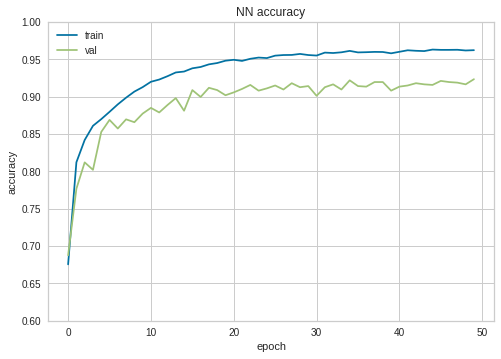

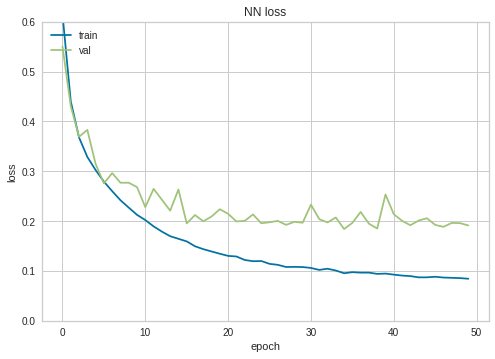

In [ ]:
#NEURAL_NETWORK_PLOT

np.random.seed(456)
set_random_seed(2)

Y_over_nn = to_categorical(Y_over, 2)

model = Sequential() 
model.add(Dense(input_dim = features_number, units=50, activation='relu', bias_regularizer=regularizers.l1_l2(l1=0.00001, l2=0.00001))) 
model.add(Dense(units=50, activation='relu', bias_regularizer=regularizers.l1_l2(l1=0.00001, l2=0.00001)))
model.add(Dense(units=50, activation='relu', bias_regularizer=regularizers.l1_l2(l1=0.00001, l2=0.00001)))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='binary_crossentropy', 
          optimizer='sgd',  
          metrics=['accuracy'])
his = model.fit(X_over_scaled.toarray(), Y_over_nn, epochs=50, batch_size=16, verbose=0, validation_split=0.15)

plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.title('NN accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.ylim(0.6, 1)
plt.show()

plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.title('NN loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.ylim(0, 0.6)
plt.show()

In [ ]:
#NEURAL NETWORK TEST PREDICTION

np.random.seed(456)
set_random_seed(2)

Y_over_nn = to_categorical(Y_over, 2)


def runNN(act, opt, ep, h_lay, un, b):
    model = Sequential() 
    model.add(Dense(input_dim = features_number, units=un , activation=act, bias_regularizer=regularizers.l1_l2(l1=0.00001, l2=0.00001))) 
    for i in range(0, h_lay):
        model.add(Dense(units=un, activation=act, bias_regularizer=regularizers.l1_l2(l1=0.00001, l2=0.00001)))
    model.add(Dense(2, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', 
              optimizer=opt,  
              metrics=['accuracy'])
    model.fit(X_over_scaled, Y_over_nn, epochs=ep, batch_size=b, verbose=1)
    results = model.predict(samples_test_scaled_nn)
    return results


result = runNN("relu", "sgd", 50, 2, 50, 16 )

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_7/dense_24/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_7/dense_24/embedding_lookup_sparse/Reshape:0", shape=(None, 50), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_7/dense_24/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


543/543 [==============================] - 2s 2ms/step - loss: 0.5967 - accuracy: 0.6675
Epoch 2/50
543/543 [==============================] - 1s 2ms/step - loss: 0.4172 - accuracy: 0.8145
Epoch 3/50
543/543 [==============================] - 1s 2ms/step - loss: 0.3473 - accuracy: 0.8464
Epoch 4/50
543/543 [==============================] - 1s 2ms/step - loss: 0.3115 - accuracy: 0.8623
Epoch 5/50
543/543 [==============================] - 1s 2ms/step - loss: 0.2828 - accuracy: 0.8769
Epoch 6/50
543/543 [==============================] - 1s 2ms/step - loss: 0.2605 - accuracy: 0.8845
Epoch 7/50
543/543 [==============================] - 1s 2ms/step - loss: 0.2389 - accuracy: 0.8976
Epoch 8/50
543/543 [==============================] - 1s 2ms/step - loss: 0.2223 - accuracy: 0.9078
Epoch 9/50
543/543 [==============================] - 1s 2ms/step - loss: 0.2089 - accuracy: 0.9127
Epoch 10/50
543/543 [==============================] - 1s 2ms/step - loss: 0.1933 - accuracy: 0.9179
Epoch 11/5

In [ ]:
test_index = test_csv.values[:, 0]
Y_result = result.argmax(axis = -1)
print(Y_result)
download_predictions_to_file(test_index, Y_result)